## The most *scenic* route problem 
#### For this, we will use the ``SiouxFalls.txt`` file but we will also generate random numbers for the scenicness of each location.
#### Then, for each edge we use we will consider its scenicness as the average of the two end points.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from gurobipy import *

#### Like the other notebook, we need to have the following folder setup.
---
```
main_folder
│   
│   Lagrangian.ipynb (or your notebook name)
│
└───Instances
│   │   Lagrangian.txt
│   │   Lagrangian_exercise.txt
│   │   Sio
│   
│   
```

In [3]:
G=nx.DiGraph()
filename="./Instances/SiouxFalls.txt"
f=open(filename)
for row in f:
    myrow=row.split()
    G.add_edge(myrow[0], myrow[1], weight=int(myrow[2]))

#### Let's add the scenicness to each node.

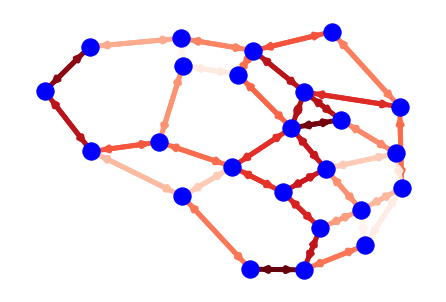

In [5]:
import random
for (i,d) in G.nodes(data=True):
    d['scenic']=random.random()*2
node_scenicness=nx.get_node_attributes(G,'scenic')
for (i,j,d) in G.edges(data=True):
    d['scenic']=(node_scenicness[i]+node_scenicness[j])/2
    
edges,edge_scenicness = zip(*nx.get_edge_attributes(G,'scenic').items())
nx.draw(G, node_color='b', edgelist=edges, edge_color=edge_scenicness, width=5, edge_cmap=plt.cm.Reds)

0.7333518392234512

In [53]:
## Here is the *true* shortest path (without any scenic requirements).
source='1'
terminal='20'
print(nx.dijkstra_path(G, source, terminal, weight='weight'))

['1', '2', '6', '8', '7', '18', '20']


### Mathematical formulation for this scenic route problem
#### Let $\boldsymbol{s_{ij}}$ be the inverse scenicness of an edge. Then:

\begin{align*}
\min & \sum_{\left(i,j\right)\in E} c_{ij} x_{ij} \\
\text{s.t.} & \sum_{j:\left(i,j\right)\in E} x_{ij}-\sum_{j:\left(j,i\right)\in E} x_{ij}=\begin{cases} 1, & \text{if $i=s$}, \\ -1, &\text{if $i=t$}, \\ 0, & \text{otherwise}. \end{cases} \\
&\sum\limits_{\left(i,j\right)\in E} s_{ij}x_{ij} \leq \ell, \\
&x_{ij}\in\left\{0,1\right\}, ~~~ \forall i\in V.
\end{align*}


In [54]:
model=Model("scenic_path")

In [55]:
# Define variables
x={}
for i in G.nodes():
    x[i]={}
for (i,j,d) in G.edges(data=True):
    x[i][j]=model.addVar(vtype=GRB.BINARY, obj=d['weight'], name='x('+str(i)+','+str(j)+')')
# Equivalently we could do:
# x=model.addVars(G.number_of_edges(), vtype=GRB.BINARY) and do objective or..

In [56]:
# Define flow preservation constraints

inc={}
out={}
for i in G.nodes():
    inc[i]=0
    out[i]=0
    
for (i,j) in G.edges():
    inc[j]+=x[i][j]
    out[i]+=x[i][j]
    
for i in G.nodes():
    if i==source:
        model.addConstr(out[i]-inc[i]==1)
    elif i==terminal:
        model.addConstr(out[i]-inc[i]==-1)
    else:
        model.addConstr(out[i]-inc[i]==0)

In [57]:
# Side constraint: scenicness above a threshold l

expr=quicksum(d['scenic']*x[i][j] for (i,j,d) in G.edges(data=True))
#Equivalently, we could do:
#expr=0
#for (i,j) in G.edges():
#    expr=x[i][j]
threshold=6
model.addConstr(expr<=threshold)

<gurobi.Constr *Awaiting Model Update*>

In [58]:
model.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 25 rows, 76 columns and 228 nonzeros
Model fingerprint: 0xac71d15c
Variable types: 0 continuous, 76 integer (76 binary)
Coefficient statistics:
  Matrix range     [7e-02, 2e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 53.0000000
Presolve removed 2 rows and 5 columns
Presolve time: 0.00s
Presolved: 23 rows, 71 columns, 191 nonzeros
Variable types: 0 continuous, 71 integer (71 binary)

Root relaxation: objective 4.391509e+01, 22 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      49.0000000   49.00000  0.00%     -    0s

Explored 0 nodes (23 simplex iterations) in 0.02 seconds
Thread c

In [26]:
for (i,j,d) in G.edges(data=True):
    if x[i][j].X==1:
        print(i,j,d['weight'], d['scenic'])

1 3 4.0 0.4448198238106753
3 12 4.0 1.1151889769960215
12 13 3.0 0.9387224932554386
13 24 18.0 0.31751587914076584
24 23 4.0 0.2479429427748483
23 22 12.0 0.32308081538769673
22 20 8.0 0.2963442087045609


## Lagrangian optimization for the shortest path with a scenic route side constraint.
#### First, we present the Lagrangian reformulation:
\begin{align*}
\min & \sum_{\left(i,j\right)\in E} \left(c_{ij}+\lambda s_{ij}\right) x_{ij}-\ell\cdot \lambda \\
\text{s.t.} & \sum_{j:\left(i,j\right)\in E} x_{ij}-\sum_{j:\left(j,i\right)\in E} x_{ij}=\begin{cases} 1, & \text{if $i=s$}, \\ -1, &\text{if $i=t$}, \\ 0, & \text{otherwise}. \end{cases} \\
&x_{ij}\in\left\{0,1\right\}, ~~~ \forall i\in V.
\end{align*}

In [59]:
import networkx as nx
import matplotlib.pyplot as plt
from gurobipy import *
from scipy import *

### Setting up the Lagrangian optimization procedure.

In [65]:
source='1'
terminal='20'
threshold=6

tau=5
alpha=0.9
lamb=0
prevlamb=100
iteration=1

In [61]:
original_costs={}
original_scenic={}
for (i,j,d) in G.edges(data=True):
    original_costs[i,j]=d['weight']
    original_scenic[i,j]=d['scenic']

In [66]:
for (i,j,d) in G.edges(data=True):
    d['weight']=original_costs[i,j]
    
def calc_val(path, vector):
    my_cost=0
    for i in range(len(path)-1):
        my_cost+=vector[path[i],path[i+1]]
    return my_cost

done=False
while(not done):
    retry=False
    print(iteration, lamb)
    for (i,j,d) in G.edges(data=True):
        d['weight']=original_costs[i,j]+lamb*original_scenic[i,j]
        
    SP=nx.shortest_path(G, source, terminal, weight='weight', method='bellman-ford')
    lagrangian_cost=nx.shortest_path_length(G, source, terminal, weight='weight')-lamb*threshold
    actualPath=nx.shortest_path(G, source, terminal, weight='weight')
    true_cost=calc_val(actualPath, original_costs)
    
    print(SP,lagrangian_cost,true_cost,calc_val(actualPath,original_scenic))
    prevLamb=lamb
    derr=calc_val(actualPath, original_scenic)-threshold
        
    lamb=lamb+derr*pow(alpha,iteration)*tau
    if lamb<0:
        lamb=0
    iteration+=1
    
    if derr<=0 and (true_cost==lagrangian_cost or abs(lamb-prevLamb)<0.001): 
        done=True     
    

1 0
['1', '2', '6', '8', '7', '18', '20'] 40.0 40 7.069455373731928
2 4.812549181793674
['1', '3', '12', '13', '24', '21', '20'] 42.31533298289251 49 4.61099247725172
3 0
['1', '2', '6', '8', '7', '18', '20'] 40.0 40 7.069455373731928
4 3.898164837252877
['1', '3', '12', '13', '24', '21', '20'] 43.58541971614293 49 4.61099247725172
5 0
['1', '2', '6', '8', '7', '18', '20'] 40.0 40 7.069455373731928
6 3.1575135181748304
['1', '2', '6', '8', '7', '18', '20'] 43.37681979964327 40 7.069455373731928
7 5.9992756845321775
['1', '3', '12', '13', '24', '21', '20'] 40.66696094314398 49 4.61099247725172
8 2.677485723496269
['1', '2', '6', '8', '7', '18', '20'] 42.8634514950836 40 7.069455373731928
9 4.9793130782457204
['1', '3', '12', '13', '24', '21', '20'] 42.083696676197796 49 4.61099247725172
10 2.2886632098066344
['1', '2', '6', '8', '7', '18', '20'] 42.447623168390265 40 7.069455373731928
11 4.153143367153691
['1', '3', '12', '13', '24', '21', '20'] 43.2312526199714 49 4.61099247725172
12 1

In [1]:
!pip install nbconvert


In [67]:
print(SP)

['1', '3', '12', '13', '24', '21', '20']


8.0
